# CONSTRUCTION OF FX VOL SURFACE - PART III

In this notebook I show how you can calibrate to the FX Vol Surface to ATM, 25D and 10D at multiple expiry dates and analyse different volatility interpolation methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.models.black_scholes import *
from financepy.products.fx import *
from financepy.market.curves.discount_curve_flat import DiscountCurveFlat
from financepy.market.volatility.fx_vol_surface_plus import *

####################################################################
#    FINANCEPY Version 1.1 - This build: 27 Aug 2025 at 13:51      #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



## Load the Volatility Market Quotes

In [3]:
value_dt = Date(10, 4, 2020)

In [4]:
for_name = "EUR"
dom_name = "USD"
for_cc_rate = 0.03460  # EUR
dom_cc_rate = 0.02940  # USD

We need to set up the option details - what you would find in the Term Sheet.

In [5]:
domestic_curve = DiscountCurveFlat(value_dt, dom_cc_rate)
foreign_curve = DiscountCurveFlat(value_dt, for_cc_rate)

In [6]:
currency_pair = for_name + dom_name
spot_fx_rate = 1.3465

I now load the option tenor, the ATM vol and the market strangle and risk-reversal quotes.

In [7]:
tenors = ['1M', '2M', '3M', '6M', '1Y', '2Y']
atm_vols = [21.00, 21.00, 20.750, 19.400, 18.250, 17.677]
ms25DeltaVols = [0.65, 0.75, 0.85, 0.90, 0.95, 0.85]
rr25DeltaVols = [-0.20, -0.25, -0.30, -0.50, -0.60, -0.562]
ms10DeltaVols = [2.433, 2.83, 3.228, 3.485, 3.806, 3.208]
rr10DeltaVols = [-1.258, -1.297, -1.332, -1.408, -1.359, -1.208]

We need to set some parameters for the vol surface.

In [8]:
notional_currency = for_name
atm_method = FinFXATMMethod.FWD_DELTA_NEUTRAL
delta_method = FinFXDeltaMethod.SPOT_DELTA
alpha = 0.5

In [9]:
fxVolSurfaceClark = FXVolSurfacePlus(value_dt, spot_fx_rate, currency_pair, notional_currency,
                                        domestic_curve, foreign_curve,
                                        tenors, atm_vols,
                                        ms25DeltaVols, rr25DeltaVols,
                                        ms10DeltaVols, rr25DeltaVols,
                                        alpha,
                                        atm_method, delta_method,
                                        VolFuncTypes.CLARK5)

In [10]:
fxVolSurfaceSABR = FXVolSurfacePlus(value_dt, spot_fx_rate, currency_pair, notional_currency,
                                       domestic_curve, foreign_curve,
                                       tenors, atm_vols,
                                       ms25DeltaVols, rr25DeltaVols,
                                       ms10DeltaVols, rr25DeltaVols,
                                       alpha,
                                       atm_method, delta_method,
                                       VolFuncTypes.SABR)

In [11]:
fxVolSurfaceBBG = FXVolSurfacePlus(value_dt, spot_fx_rate, currency_pair, notional_currency,
                                      domestic_curve, foreign_curve,
                                      tenors, atm_vols,
                                      ms25DeltaVols, rr25DeltaVols,
                                      ms10DeltaVols, rr25DeltaVols,
                                      alpha,
                                      atm_method, delta_method,
                                      VolFuncTypes.BBG)

We can examine the calibration

## Checking the Basics - Does it Recover ATM Volatility ?

In [12]:
expiry_dts = value_dt.add_tenor(tenors)

In [13]:
for i in range(0, len(expiry_dts)):
    fwd = fxVolSurfaceClark.fwd [i]
    kATM = fxVolSurfaceClark.k_atm[i]
    vATM = fxVolSurfaceClark.atm_vols[i]
    volClark = fxVolSurfaceClark.vol_from_strike_dt(kATM, expiry_dts[i])
    print("fwd", fwd, "KATM", kATM, "volATM", vATM*100, "volInterp", volClark*100)

fwd 1.3459262042602378 KATM 1.348367676745795 volATM 21.0 volInterp 21.000000000154504
fwd 1.3453335388728336 KATM 1.3503003309736141 volATM 21.0 volInterp 21.000000391202278
fwd 1.344760240207283 KATM 1.3519973574277078 volATM 20.75 volInterp 20.74999999999019
fwd 1.3430036472282152 KATM 1.3557345507916598 volATM 19.4 volInterp 19.40000000275215
fwd 1.339530242682178 KATM 1.3620243862979695 volATM 18.25 volInterp 18.246683566233653
fwd 1.3325827645184334 KATM 1.3748802277559837 volATM 17.677 volInterp 17.677020780757598


Fit is good but not perfect.

## Volatility Smile Analysis - Different Volatility Function Types

In [14]:
strikes = np.linspace(0.9, 2.0, 1000)

In [15]:
expiry_dt = value_dt.add_tenor("1Y")

In [16]:
volsClark = []
volsSABR = []
volsBBG = []

for k in strikes:
    volClark = fxVolSurfaceClark.vol_from_strike_dt(k, expiry_dt)
    volSABR = fxVolSurfaceSABR.vol_from_strike_dt(k, expiry_dt)
    volBBG = fxVolSurfaceBBG.vol_from_strike_dt(k, expiry_dt)
    volsClark.append(volClark*100.0)
    volsSABR.append(volSABR*100.0)
    volsBBG.append(volBBG*100.0)

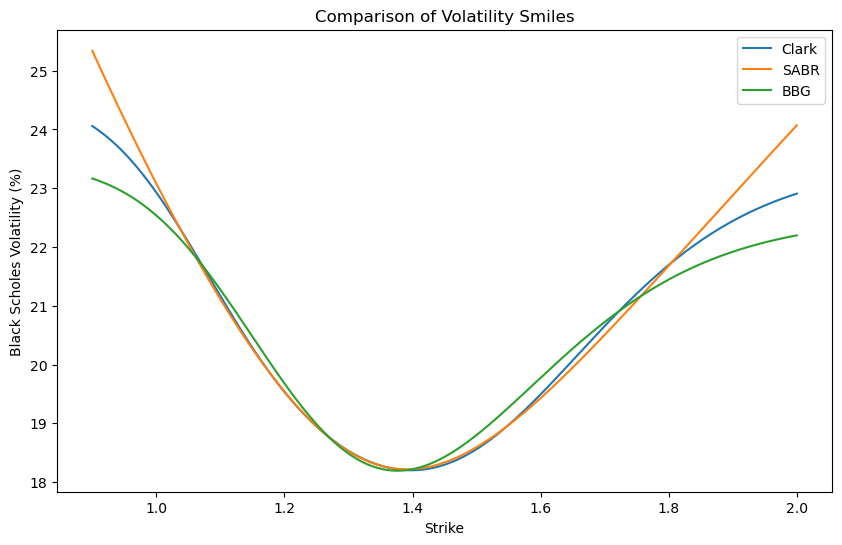

In [17]:
plt.figure(figsize=(10,6))
plt.plot(strikes, volsClark, label="Clark")
plt.plot(strikes, volsSABR, label="SABR")
plt.plot(strikes, volsBBG, label="BBG")
plt.xlabel("Strike")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Smiles")
plt.legend();

## Implied FX Rate Probability Density Functions

In [18]:
lower = 0.50
upper = 2.25
dbnClark = fxVolSurfaceClark.implied_dbns(lower, upper, 1000)
dbnSABR = fxVolSurfaceSABR.implied_dbns(lower, upper, 1000)
dbnBBG = fxVolSurfaceBBG.implied_dbns(lower, upper, 1000)

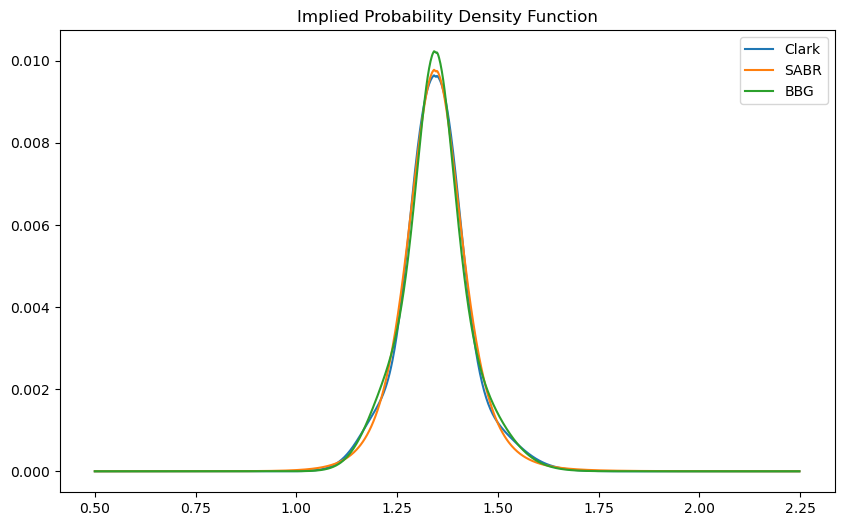

In [19]:
plt.figure(figsize=(10,6))
plt.plot(dbnClark[0]._x, dbnClark[0]._densitydx, label="Clark")
plt.plot(dbnSABR[0]._x, dbnSABR[0]._densitydx, label="SABR")
plt.plot(dbnBBG[0]._x, dbnBBG[0]._densitydx, label="BBG")
plt.title("Implied Probability Density Function")
plt.legend();

## Expiry Date Interpolation

We only have one expiry date. The volatility is therefore assumed to be flat at the level of this expiry date.

In [20]:
k = 1.35

In [21]:
years = np.linspace(0.0, 3.0, 301)

In [22]:
expiry_dts = value_dt.add_years(years)

In [24]:
volsClark = []

for expiry_dt in expiry_dts:
    volClark = fxVolSurfaceClark.vol_from_strike_dt(k, expiry_dt)
    volsClark.append(volClark*100.0)

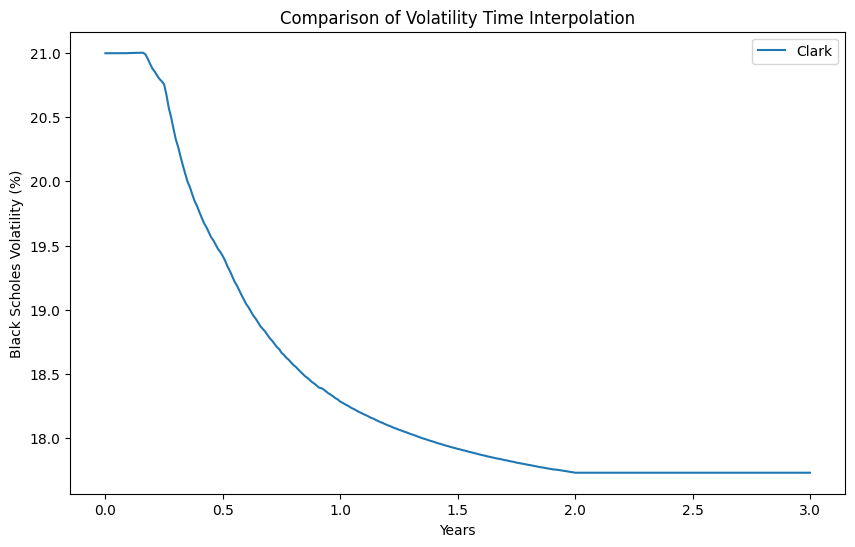

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(years, volsClark, label="Clark")
plt.xlabel("Years")
plt.ylabel("Black Scholes Volatility (%)")
plt.title("Comparison of Volatility Time Interpolation")
plt.legend();

Copyright (c) 2020, Dominic O'Kane 